In [1]:
import itertools
import os
import cv2

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("", "GPU used" if tf.config.list_physical_devices('GPU') else "No GPU")

TF version: 2.8.0
Hub version: 0.12.0
 GPU used


In [2]:
#model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2'
model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'
pixels = 224

print(f"Selected model:  {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model:  https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2
Input size (224, 224)


In [3]:
!unzip './flowers.zip'
data_dir = './flowers'

print(data_dir)

Streaming output truncated to the last 5000 lines.
  inflating: flowers/dandelion/17884609480_5abb6e7a29_c.jpg  
  inflating: flowers/dandelion/1794922981_743dab1f75_c.jpg  
  inflating: flowers/dandelion/18033617135_c5e18a3063_c.jpg  
  inflating: flowers/dandelion/18132647866_56819cbb8e_c.jpg  
  inflating: flowers/dandelion/18155620962_82f034b995_c.jpg  
  inflating: flowers/dandelion/18240083386_6e451f90e1_c.jpg  
  inflating: flowers/dandelion/18588097534_f60752313c_c.jpg  
  inflating: flowers/dandelion/18763022808_bd514c8b51_c.jpg  
  inflating: flowers/dandelion/18789920985_3d97ce51cb_c.jpg  
  inflating: flowers/dandelion/18894804492_1f88e243ff_c.jpg  
  inflating: flowers/dandelion/19063591035_781a6d2342_c.jpg  
  inflating: flowers/dandelion/19163546_bede0b9c45_c.jpg  
  inflating: flowers/dandelion/19304445_1edf226c0c_c.jpg  
  inflating: flowers/dandelion/19555106522_601c3274c8_c.jpg  
  inflating: flowers/dandelion/1957758708_e77bcfa600_c.jpg  
  inflating: flowers/dandel

In [4]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))



val_ds = build_dataset("validation")
print(val_ds)
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 12847 files belonging to 13 classes.
Using 10278 files for training.
Found 12847 files belonging to 13 classes.
Using 2569 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None))>


In [5]:

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 13)                16653     
                                                                 
Total params: 5,935,965
Trainable params: 16,653
Non-trainable params: 5,919,312
_________________________________________________________________


In [6]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.001),
  metrics=['accuracy'])

In [7]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
642/642 [==============================] - 44s 46ms/step - loss: 0.4871 - accuracy: 0.8656 - val_loss: 0.2383 - val_accuracy: 0.9352
Epoch 2/5
642/642 [==============================] - 28s 44ms/step - loss: 0.2141 - accuracy: 0.9430 - val_loss: 0.1976 - val_accuracy: 0.9496
Epoch 3/5
642/642 [==============================] - 33s 52ms/step - loss: 0.1762 - accuracy: 0.9516 - val_loss: 0.1880 - val_accuracy: 0.9508
Epoch 4/5
642/642 [==============================] - 29s 45ms/step - loss: 0.1590 - accuracy: 0.9574 - val_loss: 0.1808 - val_accuracy: 0.9512
Epoch 5/5
642/642 [==============================] - 28s 44ms/step - loss: 0.1455 - accuracy: 0.9627 - val_loss: 0.1738 - val_accuracy: 0.9535


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(13,), dtype=float32)
11


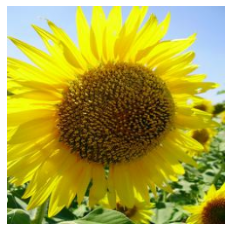

True label: sunflower
Predicted label: sunflower


In [29]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
print(y[0])
print(true_index)
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [9]:
!mkdir './flowers_t'
!unzip './flowers_test.zip' -d './flowers_t'

Archive:  ./flowers_test.zip
   creating: ./flowers_t/flowers_test/
  inflating: ./flowers_t/flowers_test/.DS_Store  
  inflating: ./flowers_t/__MACOSX/flowers_test/._.DS_Store  
  inflating: ./flowers_t/flowers_test/test_3.jpg  
  inflating: ./flowers_t/__MACOSX/flowers_test/._test_3.jpg  
  inflating: ./flowers_t/flowers_test/test_2.jpg  
  inflating: ./flowers_t/__MACOSX/flowers_test/._test_2.jpg  
  inflating: ./flowers_t/flowers_test/test_1.jpg  
  inflating: ./flowers_t/__MACOSX/flowers_test/._test_1.jpg  
  inflating: ./flowers_t/flowers_test/test_4.jpg  
  inflating: ./flowers_t/__MACOSX/flowers_test/._test_4.jpg  


Predicted label: common daisy


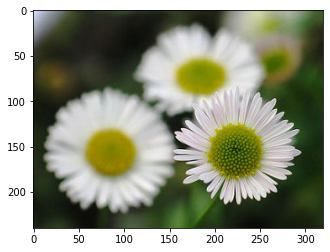

In [30]:
img = plt.imread('./flowers_t/flowers_test/test_1.jpg')
plt.imshow(img)
img_sized = tf.image.resize(img, [224, 224])
img_sized.shape

images = []
images.append(img_sized)

prediction_scores = model.predict(np.expand_dims(img_sized, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

Predicted label: common daisy


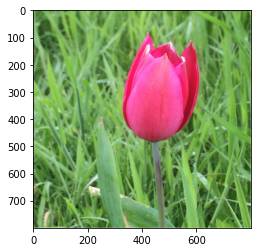

In [31]:
img = plt.imread('./flowers_t/flowers_test/test_2.jpg')
plt.imshow(img)
img_sized = tf.image.resize(img, [224, 224])
img_sized.shape
images.append(img_sized)

prediction_scores = model.predict(np.expand_dims(img_sized, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

Predicted label: common daisy


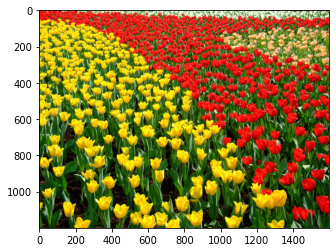

In [26]:
img = plt.imread('./flowers_t/flowers_test/test_3.jpg')
plt.imshow(img)
img_sized = tf.image.resize(img, [224, 224])
img_sized.shape
images.append(img_sized)

prediction_scores = model.predict(np.expand_dims(img_sized, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

5
Predicted label: california poppy


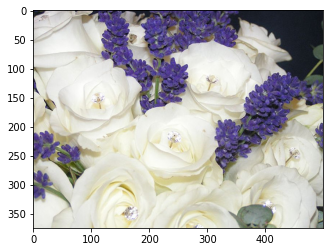

In [27]:
img = plt.imread('./flowers_t/flowers_test/test_4.jpg')
plt.imshow(img)
img_sized = tf.image.resize(img, [224, 224])
img_sized.shape
images.append(img_sized)

print(len(images))

prediction_scores = model.predict(np.expand_dims(img_sized, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

In [14]:
test_images = images
test_images = np.array(test_images)

print(test_images.shape)

(4, 224, 224, 3)


In [15]:
import sklearn.preprocessing as preprocessing
classes = ['astilbe', 'bellflower', 'black-eyed susan', 'calendula', 'california poppy','carnation', 'common daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip']

targets = np.array(classes)
labelEnc = preprocessing.LabelEncoder()
new_target = labelEnc.fit_transform(targets)
onehotEnc = preprocessing.OneHotEncoder()
onehotEnc.fit(new_target.reshape(-1, 1))
targets_trans = onehotEnc.transform(new_target.reshape(-1, 1))
labels_enc = targets_trans.toarray()
print("The original data")
print(targets)
print("The transform data using OneHotEncoder")
print(labels_enc.shape)

The original data
['astilbe' 'bellflower' 'black-eyed susan' 'calendula' 'california poppy'
 'carnation' 'common daisy' 'coreopsis' 'dandelion' 'iris' 'rose'
 'sunflower' 'tulip']
The transform data using OneHotEncoder
(13, 13)


In [16]:
test_labels = []
test_labels.append(labels_enc[6])
test_labels.append(labels_enc[12])
test_labels.append(labels_enc[12])
test_labels.append(labels_enc[10])
test_labels = np.array(test_labels)
print(test_labels)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [17]:
print(test_images[0])

[[[216.46428  225.25     242.67857 ]
  [213.60713  221.60713  240.65306 ]
  [210.74745  218.74745  239.8903  ]
  ...
  [ 63.002552  89.14284   42.244846]
  [ 61.691322  88.03571   39.002537]
  [ 60.313755  87.3061    36.32906 ]]

 [[213.57143  222.27296  239.8699  ]
  [210.6454   218.6454   238.93112 ]
  [207.57144  215.57144  236.91327 ]
  ...
  [ 63.07141   91.07141   43.06376 ]
  [ 63.        89.21429   41.107143]
  [ 63.168373  89.91583   39.788227]]

 [[213.39285  221.39285  240.46939 ]
  [209.77806  217.77806  238.19133 ]
  [205.42857  213.42857  236.42857 ]
  ...
  [ 63.05866   91.05866   42.82143 ]
  [ 63.        91.        42.114796]
  [ 64.57147   91.        42.785736]]

 ...

 [[ 27.961735  35.961735  20.961735]
  [ 27.17857   35.17857   20.17857 ]
  [ 26.584179  34.58418   19.584179]
  ...
  [ 27.581627  45.107162  19.107162]
  [ 28.714294  46.357147  20.357147]
  [ 30.647995  47.        21.      ]]

 [[ 28.892853  36.892853  21.892853]
  [ 28.823973  36.82397   21.823973]


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(1)
train_dataset = train_dataset.map(lambda images, labels:
                        (preprocessing_model(images), labels))
print(train_dataset)
model.evaluate(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.float64, name=None))>
4/4 [==============================] - 1s 14ms/step - loss: 0.0604 - accuracy: 1.0000


[0.06044870987534523, 1.0]

In [19]:
model.save('my_model.h5')
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>